<a href="https://colab.research.google.com/github/yjyjy131/plant_classifier_model/blob/main/google_image_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Selenium 및 웹 드라이버 설치

In [ ]:
!pip install Selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/crhomium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0, '/usr/lib/crhomium-browser/chromedriver')

from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

     |████████████████████████████████| 911kB 4.2MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [288 kB]
Get:14 http://arc

## 라이브러리 import

In [ ]:
import os
import time
import socket

from urllib.request import urlretrieve
from urllib.error import HTTPError, URLError
from selenium.common.exceptions import ElementClickInterceptedException,NoSuchElementException, ElementNotInteractableException
from PIL import Image

## scroll_down()

In [ ]:
def scroll_down():
  scroll_count = 0
  print("[scroll_down() : 스크롤 다운 시작]")

  last_height = wd.execute_script("return document.body.scrollHeight")
  after_click = False # 결과 더보기 버튼

  while True:
    print(f"[스크롤 다운: {scroll_count}]")
    wd.execute_script("window.scrollTo(0, document.body.scrollHeight)")
    scroll_count += 1
    time.sleep(1)

    new_height = wd.execute_script("return document.body.scrollHeight")

    if last_height == new_height:
      if after_click is True:
        break
      else:
        try :
          more_button = wd.find_element_by_xpath('//*[@id="islmp"]/div/div/div/div/div[5]/input')
          if more_button.is_displayed():
            more_button.click()
            after_click = True 
        except NoSuchElementException as e:
          print(e)
          break
    
    last_height = new_height
       

## click_and_save() 

In [ ]:
def click_and_save(dir_name, index, img, img_list_length):
  global scraped_count
  try:
    print(scraped_count)
    img.click()
    wd.implicitly_wait(3)
    src = wd.find_element_by_xpath('//*[@id="Sva75c"]/div/div/div[3]/div[2]/c-wiz/div[1]/div[1]/div/div[2]/a/img').get_attribute('src')
    if src.split('.')[-1] == 'png':
      urlretrieve(src, dir_name + '/' + str(scraped_count + 1) + ".png")
      print(f" {index+1}/{img_list_length} PNG 이미지 저장")
    else:
      urlretrieve(src, dir_name + '/' + str(scraped_count + 1) + ".jpg")
      print(f" {index+1}/{img_list_length} JPG 이미지 저장")
    
    scraped_count += 1

  except HTTPError as e:
    print(e)
    pass
  except ElementClickInterceptedException as e:
    print(e)
    pass
    


## scraping()

In [ ]:
def scraping (dir_name, query):
  global scraped_count

  url = f"https://www.google.com/search?q={query}&tbm=isch&hl=ko&tbs&sa=X&ved=0CAEQpwVqFwoTCPCU68Ogsu4CFQAAAAAdAAAAABAC&biw=1220&bih=803"
  wd.get(url)
  wd.maximize_window()

  scroll_down()

  div = wd.find_element_by_xpath('//*[@id="islrg"]/div[1]')
  img_list = div.find_elements_by_css_selector('div.bRMDJf.islir > img')

  for index, img in enumerate(img_list):
    try:
      click_and_save(dir_name, index, img, len(img_list))
    except ElementClickInterceptedException as e:
      print(e)
      wd.execute_script("window.scrollTo(0, window.scrollY + 100)")
      time.sleep(1)
      click_and_save(dir_name, index, img, len(img_list))
    except NoSuchElementException as e:
      print(e)
      wd.execute_script("window.scrollTo(0, window.scrollY + 100)")
      time.sleep(1)
      click_and_save(dir_name, index, img, len(img_list))
    except ConnectionResetError as e:
      print(e)
      pass
    except URLError as e:
      print(e)
      pass
    except socket.timeout as e:
      print(e)
      pass
    except socket.gaierror as e:
      print(e)
      pass
    except ElementNotInteractableException as e:
      print(e)
      break
  
  try:
    print("[스크래핑 종료 ( 성공률 : %.24f ) ]" % (scraped_count / len(img_list) * 100.0))
  except ZeroDivisionError as e:
    print(e)

  wd.quit()


## filter_and_remove() : 일정 해상도 이하, 손상된 이미지 제거

In [ ]:
def filter_and_remove(dir_name, query, filter_size):
  filtered_count = 0

  for index, file_name in enumerate(os.listdir(dir_name)):
    try:
      file_path = os.path.join(dir_name, file_name)
      img = Image.open(file_path)    

      if img.width < filter_size and img.height < filter_size:
        img.close()
        os.remove(file_path)
        print(f"{index} 이미지 제거")
        filtered_count += 1
    except OSError as e:
      print(e)
      os.remove(file_path)
      filtered_count += 1

  print(f"[이미지 제거 개수 : {filtered_count} / {scraped_count}]")

    

## 스크래핑 실행

검색어 입력: 길쭉한 사막 선인장
[./길쭉한 사막 선인장 디렉토리 생성]
[scroll_down() : 스크롤 다운 시작]
[스크롤 다운: 0]
[스크롤 다운: 1]
[스크롤 다운: 2]
[스크롤 다운: 3]
[스크롤 다운: 4]
[스크롤 다운: 5]
[스크롤 다운: 6]
[스크롤 다운: 7]
[스크롤 다운: 8]
[스크롤 다운: 9]
[스크롤 다운: 10]
[스크롤 다운: 11]
0
 1/876 JPG 이미지 저장
1
 2/876 JPG 이미지 저장
2
 3/876 JPG 이미지 저장
3
 4/876 JPG 이미지 저장
4
 5/876 JPG 이미지 저장
5
 6/876 JPG 이미지 저장
6
 7/876 JPG 이미지 저장
7
Message: element click intercepted: Element  is not clickable at point (230, 558). Other element would receive the click: <div jsname="r5xl4" class="islrc" style="width: 440px;">...</div>
  (Session info: headless chrome=87.0.4280.66)

7
 9/876 JPG 이미지 저장
8
 10/876 JPG 이미지 저장
9
 11/876 JPG 이미지 저장
10
 12/876 JPG 이미지 저장
11
 13/876 JPG 이미지 저장
12
 14/876 JPG 이미지 저장
13
 15/876 JPG 이미지 저장
14
 16/876 JPG 이미지 저장
15
 17/876 JPG 이미지 저장
16
 18/876 JPG 이미지 저장
17
 19/876 JPG 이미지 저장
18
 20/876 JPG 이미지 저장
19
 21/876 JPG 이미지 저장
20
 22/876 JPG 이미지 저장
21
 23/876 JPG 이미지 저장
22
Message: element click intercepted: Element <img class="rg_i Q4LuWd" data-src
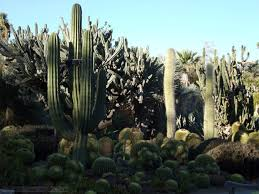

In [ ]:
socket.setdefaulttimeout(30)

wd = webdriver.Chrome('chromedriver', options=chrome_options)
scraped_count = 0

path = "./"
query = input("검색어 입력: ")

dir_name = path + query
os.makedirs(dir_name)
print(f"[{dir_name} 디렉토리 생성]")

scraping(dir_name, query)
filter_and_remove(dir_name, query, 0)

In [ ]:
!ls
#!rmdir 'wearing adidas shoes'

 sample_data   'zelkova tree OR maple tree'
'Snake Plant'  'zelkova tree OR maple tree.zip'


In [ ]:
!zip -r '길쭉한 사막 선인장.zip' '길쭉한 사막 선인장/'
from google.colab import files
files.download('./길쭉한 사막 선인장.zip')

  adding: 길쭉한 사막 선인장/ (stored 0%)
  adding: 길쭉한 사막 선인장/242.jpg (deflated 0%)
  adding: 길쭉한 사막 선인장/58.jpg (deflated 2%)
  adding: 길쭉한 사막 선인장/709.jpg (deflated 1%)
  adding: 길쭉한 사막 선인장/638.jpg (deflated 5%)
  adding: 길쭉한 사막 선인장/777.jpg (deflated 3%)
  adding: 길쭉한 사막 선인장/87.jpg (deflated 1%)
  adding: 길쭉한 사막 선인장/279.jpg (deflated 1%)
  adding: 길쭉한 사막 선인장/677.jpg (deflated 0%)
  adding: 길쭉한 사막 선인장/252.jpg (deflated 0%)
  adding: 길쭉한 사막 선인장/527.jpg (deflated 0%)
  adding: 길쭉한 사막 선인장/578.jpg (deflated 1%)
  adding: 길쭉한 사막 선인장/831.jpg (deflated 1%)
  adding: 길쭉한 사막 선인장/789.jpg (deflated 3%)
  adding: 길쭉한 사막 선인장/479.jpg (deflated 0%)
  adding: 길쭉한 사막 선인장/630.jpg (deflated 4%)
  adding: 길쭉한 사막 선인장/801.jpg (deflated 0%)
  adding: 길쭉한 사막 선인장/471.jpg (deflated 0%)
  adding: 길쭉한 사막 선인장/189.jpg (deflated 0%)
  adding: 길쭉한 사막 선인장/571.jpg (deflated 1%)
  adding: 길쭉한 사막 선인장/201.jpg (deflated 0%)
  adding: 길쭉한 사막 선인장/707.jpg (deflated 0%)
  adding: 길쭉한 사막 선인장/672.jpg (deflated 4%)
  adding: 길쭉한 사막 선인장/7

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>